## Plot RSAM v1.2

jumlah hari 22
jumlah menit 31680
win size 63

File ditemukan : 
202506_VG_MLLR_EHZRSAM10Min.DAT
________________________________

Data (5 baris pertama dan terakhir) :
                    Time  RSAM
0    2025-06-01 00:00:00    83
1    2025-06-01 00:10:00    76
2    2025-06-01 00:20:00    77
3    2025-06-01 00:30:00    73
4    2025-06-01 00:40:00    74
...                  ...   ...
3005 2025-06-21 23:10:01   121
3006 2025-06-21 23:20:01   126
3007 2025-06-21 23:30:01   119
3008 2025-06-21 23:40:01    86
3009 2025-06-21 23:50:01    71

[3010 rows x 2 columns]


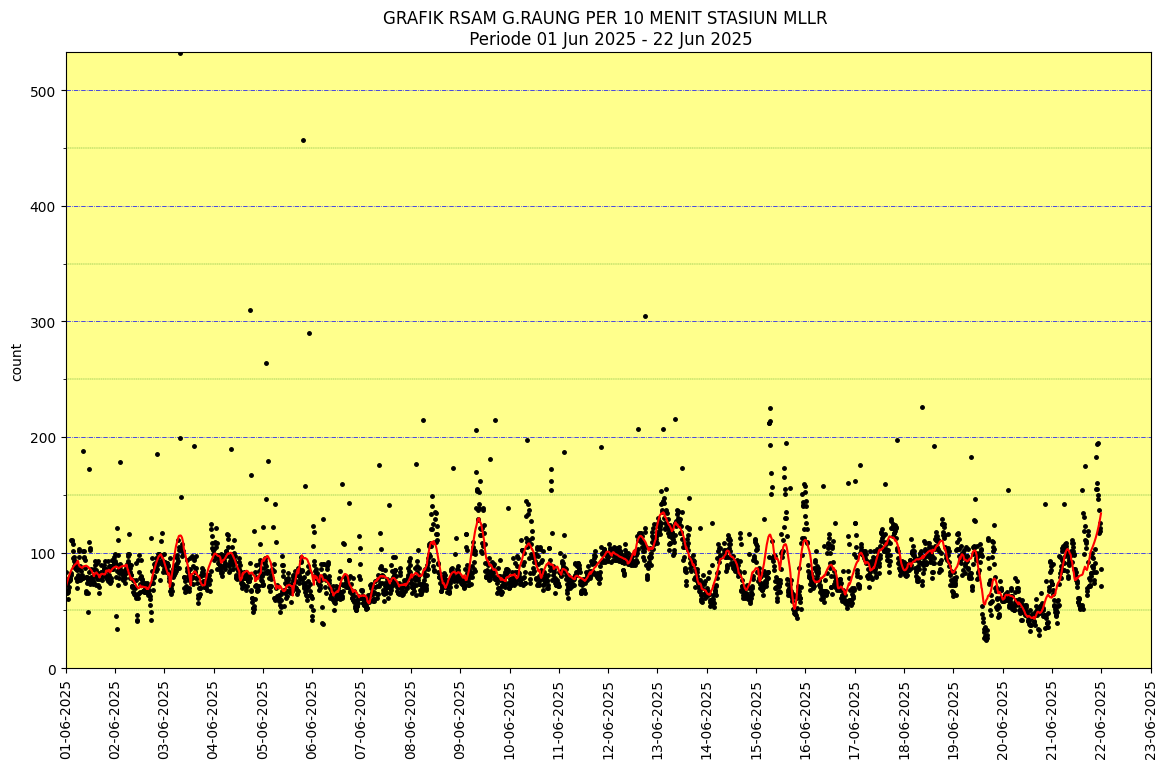

Data Terakhir : 22-Jun-2025 06:50 WIB
Nilai RSAM : 71


In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from scipy.signal import savgol_filter

# Definisikan directory data, nama gunung, dan nama stasiun
directory = r"//angsa/data/Rsam/10Minute"
gunung = 'RAUNG'
stasiun = "MLLR"

# Tentukan waktu awal dan waktu akhir
waktu_awal = '01-06-2025'
waktu_akhir = '22-06-2025'
interval_hari = 1

# Interval sumbu Y
major_interval = 100
minor_interval = 50

# Mengambil nilai bulan dan tahun
start_year = int(waktu_awal[6:])
start_month = int(waktu_awal[3:5])
end_year = int(waktu_akhir[6:])
end_month = int(waktu_akhir[3:5])

# Proses menggabungkan file-file 
# Nama file harus memiliki format standar earthworm, yaitu "yyyymm_network_station_componentRSAM10Min.DAT", contoh "202401_VG_MLLR_EHZRSAM10Min.DAT"
merged_data = pd.DataFrame()
files_to_merge = []  
for filename in os.listdir(directory):
    if filename.endswith(".DAT"):
        # Membaca nama file
        try:
            year = int(filename[:4])
            month = int(filename[4:6])
            channel_name = filename[10:14]
        except ValueError:
            # Skip file jika tidak dapat di-parse sebagai angka untuk tahun dan bulan
            continue
        # Memeriksa apakah file cocok dengan kriteria sesuai nama stasiun, waktu awal, dan waktu akhir yang ditentukan sebelumnya
        if (start_year < end_year):
            if ((year == start_year and month >= start_month) or (year == end_year and month <= end_month) or (year > start_year and year < end_year)) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)
        else:
            if (year == start_year and month >= start_month and year == end_year and month <= end_month) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)

merged_data['Time'] = pd.to_datetime(merged_data['Time'], format='%d-%b-%Y %H:%M:%S')

start_date = datetime.strptime(waktu_awal, '%d-%m-%Y')
end_date = datetime.strptime(waktu_akhir, '%d-%m-%Y')
end_date += timedelta(days=1)
data_bulan = merged_data[(merged_data['Time'] >= start_date) & (merged_data['Time'] <= end_date)]

# Mengeplot data
plt.figure(figsize=(14, 8))
plt.plot(data_bulan['Time'], data_bulan['RSAM'], label='RSAM', marker='.', markersize=5, linestyle='', color='black')

end_date -= timedelta(days=1)
formatted_start_date = start_date.strftime('%d %b %Y')
formatted_end_date = end_date.strftime('%d %b %Y')

plt.title(f'GRAFIK RSAM G.{gunung} PER 10 MENIT STASIUN {stasiun} \n Periode {formatted_start_date} - {formatted_end_date}')
end_date += timedelta(days=1)

# Savitzky-Golay smoothing
jumlah_hari = end_date - start_date
days = jumlah_hari.days
minutes = days * 1440
win_size = int(minutes / 500)

print("jumlah hari", days)
print("window size smoothing :", win_size)

window_size = win_size  # Panjang jendela smoothing
degree = 3        # Derajat polinomial
smoothed_data = savgol_filter(data_bulan['RSAM'], window_size, degree)
plt.plot(data_bulan['Time'], smoothed_data, linestyle='-', color='red')

# Nilai maksimum count pada data :
nilai_maksimal_data = int(max(data_bulan['RSAM'])) + 1

# Nilai maksimum count pada grafik bisa diubah di sini bila 'nilai_maksimum_custom' yang digunakan :
nilai_maksimum_custom = 1001

# Pilih nilai maksimum yang ingin digunakan 'nilai_maksimal_data' atau 'nilai_maksimum_custom'
nilai_maksimum = nilai_maksimal_data

plt.gca().set_ylim(0, nilai_maksimum)
plt.xlim(start_date, end_date)
plt.yticks(range(0, nilai_maksimum, major_interval))
plt.ylim(0)

plt.grid(which='major', axis='y', linestyle='-.', color='blue', linewidth=0.5)
plt.grid(which='minor', axis='y', linestyle='--', color='green', linewidth=0.25)

days = mdates.DayLocator(interval=interval_hari)
plt.gca().xaxis.set_major_locator(days)
# plt.gca().xaxis.set_major_locator(days)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=90)
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(minor_interval))
plt.ylabel('count')

def normal(start, end):
    plt.axvspan(start, end, facecolor='lime', alpha=0.35)

def waspada(start, end):
    plt.axvspan(start, end, facecolor='yellow', alpha=0.45)

def siaga(start, end):
    plt.axvspan(start, end, facecolor='orange', alpha=0.5)

def awas(start, end):
    plt.axvspan(start, end, facecolor='red', alpha=0.55)

# Memberi warna background sesuai status, ganti tanggal perubahan status sesuai histori, hapus/comment baris yang tidak perlu
normal(pd.to_datetime('01/01/2023', format='%d/%m/%Y'), pd.to_datetime('19/12/2023', format='%d/%m/%Y'))
waspada(pd.to_datetime('19/12/2023', format='%d/%m/%Y'), pd.to_datetime('30/06/2025', format='%d/%m/%Y'))
# siaga(pd.to_datetime('19/05/2023', format='%d/%m/%Y'), pd.to_datetime('31/08/2023', format='%d/%m/%Y'))
# awas(pd.to_datetime('21/07/2023', format='%d/%m/%Y'), pd.to_datetime('31/07/2023', format='%d/%m/%Y'))

print("\nFile ditemukan : ")
for item in files_to_merge:
    print(item)
print("________________________________")
print("\nData (5 baris pertama dan terakhir) :")
print(data_bulan)
plt.show()

last_row = merged_data.iloc[-1]

timestamp_terakhir = last_row['Time']
rsam_terakhir = last_row['RSAM']
utc7 = timestamp_terakhir + pd.Timedelta(hours=7)
wib_time = utc7.strftime('%d-%b-%Y %H:%M')

print("Data Terakhir :", wib_time, "WIB")
print("Nilai RSAM :", rsam_terakhir)

#@Mukijo-PVMBG, 2023
#0856-4334-6785